#### This is used to go in the same directory as when everything is run under Pycharm in a normal python file

In [1]:
import os
cwd = os.getcwd()
print(cwd)

C:\Users\Fede\Documents\GitHub\RelGAN\src\topic_modelling


In [2]:
os.chdir("..")
os.chdir("..")
cwd = os.getcwd()
print(cwd)
assert cwd.endswith("RelGAN")

C:\Users\Fede\Documents\GitHub\RelGAN


Qua dobbiamo avere RelGAN

### Test new data_loader

In [3]:
import numpy as np
from nltk.stem import PorterStemmer as ps

In [4]:
from src.topic_modelling.lda_topic import train_specific_LDA, get_corpus, LDA

coco = True
corpus_raw = get_corpus(coco)
lda = train_specific_LDA(corpus_raw, num_top=3, passes=2, iterations=2, chunksize=2000, coco=coco)

Model loaded


In [5]:
corpus_raw

['a bicycle replica with a clock as the front wheel.',
 'a black honda motorcycle parked in front of a garage.',
 'a room with blue walls and a white sink and door.',
 'a car that seems to be parked illegally behind a legally parked car',
 'a large passenger airplane flying through the air.',
 'there is a gol plane taking off in a partly cloudy sky.',
 'blue and white color scheme in a small bathroom.',
 'this is a blue and white bathroom with a wall sink and a lifesaver on the wall.',
 'a blue boat themed bathroom with a life preserver on the wall',
 'the bike has a clock as a tire.',
 'a honda motorcycle parked in a grass driveway',
 'two cars parked on the sidewalk on the street',
 'an airplane that is, either, landing or just taking off.',
 'a bathroom with walls that are painted baby blue.',
 'a bathroom with a toilet, sink, and shower.',
 'a long empty, minimal modern skylit home kitchen.',
 'an office cubicle with four different types of computers.',
 'a bathroom sink with toile

In [6]:
lda_model = lda.lda_model
from gensim.models import LdaModel

assert isinstance(lda_model, LdaModel)
lda_model

In [7]:
topics = lda_model.get_topics()

In [8]:
dictionary = lda.dictionary
print([dictionary[x[0]] for x in lda_model.get_topic_terms(1)])


['bathroom', 'toilet', 'sink', 'wall', 'cat', 'window', 'mirror', 'airplane', 'sky', 'shower']


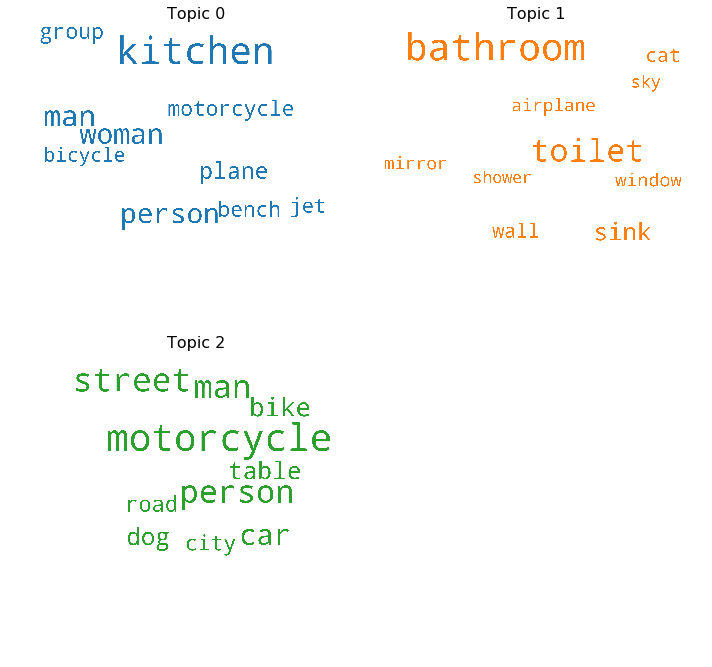

In [17]:
from src.topic_modelling.lda_utils import word_cloud
%matplotlib inline

word_cloud(lda)

#### Create Topic Vector for sentences in the dataset

In [17]:
import pandas as pd
import re
import nltk
from nltk.corpus import wordnet

from gensim.utils import lemmatize, simple_tokenize

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def process_texts(input_texts, stops):
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    final = []
    for i in input_texts:
        texts = (re.sub(r"http\S+", "", i))
        # tokenize
        texts = simple_tokenize(texts)
        # lower case
        texts = [word.lower() for word in texts]
        # remove stopwords
        texts = [word for word in texts if word not in stops]

        # automatically detect common phrases
        sentence = ' '.join(texts)
        texts = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence)]
        # texts = [str(word).split('/')[0].split('b\'')[1] for word in lemmatizer.lemmatize(sentence)]  # , allowed_tags=re.compile('(NN)'), min_length=2)]

        final.append(texts)
    return final

def get_perc_sent_topic(ldamodel, corpus, texts, stops):
    # Init output
    sent_topics_df = pd.DataFrame()
    texts = process_texts(texts, stops)

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list

        # row = sorted(row, key=lambda x: (x[1]), reverse=True) # sort list to get dominant topic
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        to_append = []
        for j, (topic_num, prop_topic) in enumerate(row):
            # if j == 0:  # => dominant topic
            #     wp = ldamodel.show_topic(topic_num)
            #     topic_keywords = ", ".join([word for word, prop in wp])
            #     sent_topics_df = sent_topics_df.append(
            #         pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
            # else:
            #     break
            to_append.append(prop_topic)
        sent_topics_df = sent_topics_df.append(pd.Series(to_append), ignore_index=True)
    sent_topics_df.columns = ["Topic {}".format(topic_number) for topic_number in range(len(to_append))]

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df = sent_topics_df.reset_index()
    return sent_topics_df


In [18]:
from src.topic_modelling.lda_topic import get_dominant_topic_and_contribution

df = get_perc_sent_topic(ldamodel=lda.lda_model, corpus=lda.corpus_bow, texts=lda.corpus_text, stops=lda.stops)

In [19]:
df.head(5)

,index,Topic 0,Topic 1,Topic 2,0
0,0,0.526208,0.369791,0.104001,"[bicycle, replica, clock, front, wheel]"
1,1,0.463529,0.096081,0.440390,"[black, honda, motorcycle, park, front, garage]"
2,2,0.094993,0.700150,0.204857,"[room, blue, wall, white, sink, door]"
3,3,0.118244,0.117363,0.764393,"[car, seem, park, illegally, behind, legally, ..."
4,4,0.668458,0.217928,0.113614,"[large, passenger, airplane, fly, air]"


In [29]:
topic_matrix = lda.lda_model.get_topics() #  3 topics * 2280 words

In [33]:
topic_num = 3
topic_weights = df.values[:, 1:topic_num + 1]
sentences_number = topic_weights.shape[0]
word_count = topic_matrix.shape[1]
size = ((int(sentences_number), int(word_count)))
print("Topic sentnece dim: {}".format(size))
topic_sentences = np.zeros(size)

Topic sentnece dim: (10000, 2280)


In [34]:
topic_weights[:, 0]

array([0.5262081623077393, 0.46352916955947876, 0.09499283879995346, ...,
       0.11363085359334946, 0.5270355939865112, 0.8309606909751892],
      dtype=object)

In [91]:
for index in range(topic_sentences.shape[0]):
    topic_sentences[index] = np.dot(np.expand_dims(topic_weights[index], 0), topic_matrix).squeeze()
topic_sentences = np.divide(topic_sentences,np.sum(topic_sentences, axis=1, keepdims=True))

In topic_sentneces ho per ogni sentence il topic 'pesato'

In [36]:
index_dict = lda.dictionary
index

9999

than I have to make this vector of the same size of the vector used by the model (circa 4k) keeping the parallelism between words

In [38]:
from src.path_resolution import resources_path
from src.utils.text_process import text_precess
dataset = "image_coco"
data_file = resources_path("data", '{}.txt'.format(dataset))
seq_len, vocab_size, word_index_dict, index_word_dict = text_precess(data_file)

In [39]:
lda_word_index_dict = lda.dictionary.token2id
model_index_word_dict = {v: k for k, v in word_index_dict.items()}
lda_index_word_dict = lda.dictionary.id2token
model_word_index_dict = word_index_dict

In [45]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
texts = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in model_word_index_dict.keys()]

def get_model_index(lda_index):
    word = lda_index_word_dict[lda_index]
    #print("{} is word {}".format(lda_index, word))
    try:
        return model_word_index_dict[word]
    except KeyError:
        return [index for index in range(len(texts)) if texts[index] == word]

real_vector = np.zeros((topic_sentences.shape[0], len(model_index_word_dict)))
inverse_indexes = [get_model_index(i) for i in range(len(lda_index_word_dict))]

['3893', '120', '706', '3363', '4000', '2846', '3519', '1491', '3760', '1624', '1720', '2155', '3214', '3260', '58', '1556', '2624', '1100', '1919', '2653', '779', '3678', '2069', '1979', '2118', '3894', '3787', '4490', '2881', '861', '4379', '4273', '981', '3308', '1894', '4587', '1499', '1920', '3494', '243', '2008', '198', '2814', '182', '4652', '951', '2134', '3146', '2598', [392], '176', '704', '1731', '2402', '617', '2700', '1274', '1087', '1356', '2778', '1852', '2737', '2461', '3123', '3697', '2572', '1335', '1420', '4198', '968', '3964', '4349', '1581', '1912', '2204', '4533', '910', '366', '1546', '4239', '0', '2415', '893', '470', '2804', '2628', '2717', '2336', '4405', '138', '2538', '1232', '1357', '276', '1262', '2715', '3000', '3816', '2822', '4335', '4619', '3406', '2926', '1917', '3939', '938', '3369', '497', '4662', '2307', '331', '1342', '2201', '4215', '3381', '3414', '3292', '3486', '1576', '294', '1186', '1903', '822', '4527', '757', '3396', '4099', '2143', '2783'

In [76]:
model_index_word_dict['0']
model_index_word_dict

{'0': 'person',
 '1': 'fish',
 '2': 'grab',
 '3': 'closing',
 '4': 'muddy',
 '5': 'creamy',
 '6': 'guacamole',
 '7': 'towards',
 '8': 'goofy',
 '9': 'jumps',
 '10': 'batter',
 '11': 'siking',
 '12': 'library',
 '13': 'destination',
 '14': 'ring',
 '15': 'feeling',
 '16': 'run',
 '17': 'pier',
 '18': 'messy',
 '19': 'sunken',
 '20': 'bed',
 '21': 'party',
 '22': 'smirking',
 '23': 'unmade',
 '24': 'hair',
 '25': 'pan',
 '26': 'egyptair',
 '27': 'bight',
 '28': 'bangkok',
 '29': 'take',
 '30': 'preparation',
 '31': 'blurs',
 '32': 'sniffing',
 '33': 'rather',
 '34': 'floats',
 '35': 'penn',
 '36': 'zebras',
 '37': 'dual',
 '38': 'also',
 '39': 'poking',
 '40': 'messing',
 '41': 'peephole',
 '42': 'cash',
 '43': 'umbrellas',
 '44': 'hipster',
 '45': 'across',
 '46': 'mid',
 '47': 'bag',
 '48': 'kind',
 '49': 'tubs',
 '50': 'tip',
 '51': 'build',
 '52': 'maneuvers',
 '53': 'biplanes',
 '54': 'squats',
 '55': 'bake',
 '56': 'sitiing',
 '57': 'farmer',
 '58': 'gol',
 '59': 'pulled',
 '60': '

In [77]:
model_word_index_dict['a']

'418'

In [47]:
len(lda_index_word_dict)

2280

In [92]:
for ind, invere_index in enumerate(inverse_indexes):
    if isinstance(invere_index, list):
        # more than one index in the model because of lemmatization
        for x in invere_index:
            real_vector[:, x] = topic_sentences[:, ind]
    else:
        invere_index = int(invere_index)
        real_vector[:, invere_index] = topic_sentences[:, ind] 

Adesso nel real vector (num_sentences, model_word_number) c'è il topic vector estratto da LDA per ogni frase nel modello

In [93]:
real_vector_without_zeros = real_vector[~(real_vector==0)].reshape(10000, -1)

In [94]:
df_real_vector = pd.DataFrame(data=real_vector_without_zeros,    # values
                    index=range(real_vector_without_zeros.shape[0]),    # 1st column as index
                    columns=range(real_vector_without_zeros.shape[1])) 

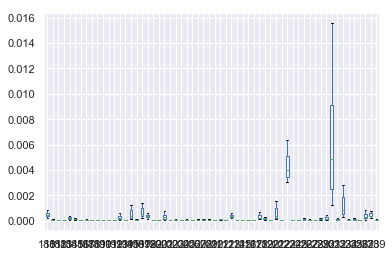

In [95]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
#x = range(real_vector_without_zeros.shape[1])
i= 3
df_real_vector[df_real_vector.columns[60*i:(i+1)*60]].boxplot()
#ax = sns.lineplot(x="words", y="% of word in topic distrib", data=df_real_vector)

In [96]:
dict_index_mean = {}
for ind, m in enumerate(real_vector.mean(axis=0)):
    dict_index_mean[str(ind)] = m

In [97]:
mean_list = []
for word, mean in zip(model_index_word_dict.values(), dict_index_mean.values()):
    mean_list.append((word, mean))

In [98]:
mean_list.sort(key = lambda x: x[1], reverse = True) 

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_yscale'

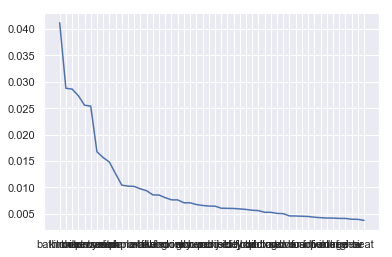

In [103]:
mean_list_reduced = mean_list[:50]
plt.plot([x[0] for x in mean_list_reduced], [x[1] for x in mean_list_reduced])
plt.set_yscale("log", nonposy='clip')
plt.show()

In [100]:
mean_list_reduced

[('bathroom', 0.041161972976857746),
 ('kitchen', 0.028757011240029124),
 ('toilet', 0.028605799962849825),
 ('man', 0.027366602739256497),
 ('motorcycle', 0.02555880378735648),
 ('person', 0.025380352853014067),
 ('street', 0.016740905638885972),
 ('woman', 0.015660320264653412),
 ('sink', 0.01480645476062962),
 ('car', 0.012592562958096125),
 ('plane', 0.010434836356729293),
 ('airplane', 0.010248139236495583),
 ('cat', 0.010194715622757993),
 ('wall', 0.009728359152960669),
 ('bike', 0.009377092467919922),
 ('table', 0.008595892895416946),
 ('dog', 0.008556281996013475),
 ('window', 0.008062687811949562),
 ('room', 0.007654697834144224),
 ('mirror', 0.007643353832265017),
 ('sky', 0.007102818162817205),
 ('group', 0.007094565916609963),
 ('shower', 0.00676763124979766),
 ('bench', 0.006592131353095775),
 ('road', 0.006476975278793831),
 ('cabinet', 0.006465889258976183),
 ('jet', 0.006073340599954906),
 ('side', 0.006046997594713384),
 ('city', 0.006020424199531549),
 ('bicycle', 0.

## Random Tests

In [68]:
import random

In [75]:
a = np.random.random((500,3))
a = np.divide(a, np.sum(a, axis=1, keepdims=True))

In [77]:
a[:10]

array([[0.29325824, 0.11846726, 0.58827451],
       [0.32129758, 0.2016563 , 0.47704612],
       [0.2020702 , 0.33933567, 0.45859412],
       [0.2108366 , 0.45901415, 0.33014925],
       [0.13388243, 0.7454518 , 0.12066577],
       [0.31947425, 0.36904078, 0.31148497],
       [0.08013777, 0.40400099, 0.51586124],
       [0.20583165, 0.2379598 , 0.55620855],
       [0.79741269, 0.17225662, 0.03033069],
       [0.07584725, 0.33771066, 0.58644209]])

## Print topic distributions

In [20]:
import copy
df_topic = copy.copy(df)
df_topic.set_index('index', inplace=True)

In [28]:
df_topic

,Topic 0,Topic 1,Topic 2,0
index,,,,
0,0.526208,0.369791,0.104001,"[bicycle, replica, clock, front, wheel]"
1,0.463529,0.096081,0.440390,"[black, honda, motorcycle, park, front, garage]"
2,0.094993,0.700150,0.204857,"[room, blue, wall, white, sink, door]"
3,0.118244,0.117363,0.764393,"[car, seem, park, illegally, behind, legally, ..."
4,0.668458,0.217928,0.113614,"[large, passenger, airplane, fly, air]"
5,0.246225,0.661202,0.092574,"[gol, plane, take, partly, cloudy, sky]"
6,0.083542,0.832719,0.083739,"[blue, white, color, scheme, small, bathroom]"
7,0.058206,0.882170,0.059624,"[blue, white, bathroom, wall, sink, lifesaver,..."
8,0.102283,0.812030,0.085687,"[blue, boat, theme, bathroom, life, preserver,..."
